### Clustering of Tweets

Having done the embeddings, can we find meaningful structure in the data? We have seen some nice preliminary results based on visualization tools. Most importantly, hashtags (topics) seem to define clusters. 


Some questions of interest which relate directly to polarization in US politics
- Clustering all tweets, do we get two meaningful cluster representing left and right (extremes)
- What are inter- and intra-cluster dissimilarities?
- Are users consistently tweeting inside one cluster or are they changing?
- The best indicator for polarization would be to find two clusters which are very different
- We can further check whether there are distinct cluster in one particular topic. For example we take the BlackLivesMatter hashtag and check whether tweets in this hashtag seperate and thus try to polarize the discussion.


### How can we cluster?

##### K-means
- Classical centroid based approach
- Influenced by noise
- Find optimal nr of clusters based on elbow method
- Might need multiple runs due to convergence to local optima
- Key disadvantage: "Spherical clusters", does not allow for intricate shapes

##### DBScan
- Density based approach
- Group points together that are in a dense region
- Allows for more intricate structures
- Allows for noise and outliers

How DBScan Works:
- Minimum density level estimation, based on a threshold for the number of neighbors, $minPts$ within the radius $\epsilon$ with an arbitrary distance measure
- Objects with more than $minPts$ neighbors within this radius are considered core points
- The intuition behind DBSCAN is to find the areas which satisfy the minimum density and which are seperated by areas of lower density
- All neighbors within the $\epsilon$ radius of a core point are considered to be part of the same cluster as the core point ("direct-density-reachable")
- If any of these neighbors is again a core point, their neighborhoods are density reachable
- Non-core points are called border points and all points within the same set are density connected
- Points which are not density reachable from any core point are considered noise and do not belong to any cluster

DBScan Params:
- eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other. We have normalized data, so don't need to worry too much about scale
- min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
- metric
- n_jobs

Heuristics for setting DBScan parameters (as mentioned by developers)
http://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf
- $minPts$ = ```min_samples``` purpose is to smooth out density estimate. For datasets that have lot of noise, are very large and high dimensional (so definitely ours) it makes sense to reduce the value of minPts below the default of 4 (choose 2-3)
- $\epsilon$ = ```eps```, radius parameter, harder to set. Should be choosen as small as possible. Unfortunately there's no domain knowledge because distances are essentially arbitrary. Better: 𝑘-distance graph (with 𝑘=𝑚𝑖𝑛𝑃𝑡𝑠) and look for an elbow in this graph. We compute the distance of the k-nearest neighbors for a sample of the tweets and look at the elbow plot of distances. Choose ```eps``` as the (hopefully) visible elbow.

#### What do we need to be aware of?
- Curse of dimensionality: We have 100 dimensions due to our embedding
- Parameters: For every algorithm we have to be aware of the parameter choices, in k-means nr of clusters, DBScan min samples and eps



In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

# Clustering algos to test
from sklearn.cluster import DBSCAN, MiniBatchKMeans

# NLP Stuff
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# WordClouds
from utils.wordcloud import plot_wordcloud


### Loading

Let's remove retweets right away, these will naturally cluster if they are all pushing the same tweets.

In [2]:
data = pd.read_pickle("../data/tweets_final.pickle")    

data = data[data.is_retweet ==False].copy()

# Drop all these duplicate "bot" tweets
data.drop_duplicates(subset = "tweet_text", keep = "first", inplace=True)

In [3]:
data.shape

(1114083, 108)

#### K-Means Clustering

- Make Elbow plot
- n_clusters gives the number of centroids
- init: random, start randomly
- n_init: Number of runs over random seeds

Returns:
- cluster_centers: Coordinates of the cluster centers
- labels_ : Labels of each point
- intertia: Sum of squared distances of samples to their closest cluster center

In [5]:
# List to store sum of squared distances
ssqd = []

# Number of random samples to take each size 100.000:
random_samples = 10

# Loop through different choices of k, store sum of squared distances
for k in range(1, 8):
    print(f"k:{k}")
    kmeans = MiniBatchKMeans(n_clusters=k,n_init= 5,batch_size=1000, compute_labels=True)

    temp = []
    for r_n in range(0,random_samples):
        
        sample = data.loc[:,data.columns[-100:]].values[np.random.randint(0,data.shape[0],size = 100000),:]
        
        kmeans.fit(sample)
        
        temp.append(kmeans.inertia_)
        
    ssqd.append(np.mean(temp))


k:1
k:2
k:3
k:4
k:5
k:6
k:7


Elbow plot:

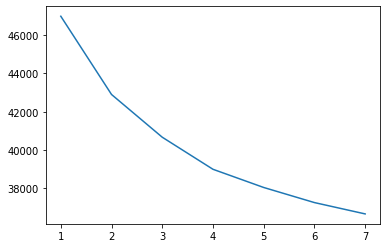

In [6]:
sns.lineplot(x= range(1,len(ssqd)+1), y = ssqd)

Okay, we get two clusters. Let's cluster the full data set and see whether there's any meaningful structure.

In [7]:
# Kmeans with two clusters
kmeans = MiniBatchKMeans(n_clusters=2,n_init= 5,batch_size=1000, compute_labels=True)

#fit
kmeans.fit(data.loc[:,data.columns[-100:]].values)
    
# Assign K-Means label
labels  =  kmeans.labels_

data["kmeans_label"] = labels

Let's see whether we can find any information in the clusters found by k-means

In [8]:
data.kmeans_label.mean()

0.6709320580244021

We cluster half the tweets as label 0 the other half as label 1.

In [9]:
# Super conservative account
data[data.user_screen_name == "redlanews"]["kmeans_label"].mean()

0.16133246244284782

In [10]:
# Super liberal account
data[data.user_screen_name == "gloed_up"]["kmeans_label"].mean()

0.19870783562467131

Well, seems like these guys are more or less in the same cluster. Let's find users by cluster.

In [12]:
user_labels = data.groupby("user_screen_name")["kmeans_label"].mean()

In [13]:
user_labels[user_labels >= 0.9]

user_screen_name
020234c2ed714e42d237538a68f278ed45d82c94a2a22e9525adcae56cc63dc6    1.000000
024c16a668e177e623f072aa23dd8d51b07fedef9133ab54b3392f60a380f7a1    1.000000
080da9e6b0c293d8e7abe6115605790ec8bc9a5c75a2b3e60539e67e3f100875    0.951851
1b9170131042e19616d129cd641647fa410216ccd3f44c92cb8529bc7f64a982    0.953452
1e97dae1559f2dbbeeec28c36953b8b79ec7de9af898d06911cee1587061a582    1.000000
23dde95f6135ab333fab997ea397603ddf208d1f91a43846f0a162581949fa0c    0.970574
2b6aa3cefe3de121f092b97804112d27045a389be225c9d4e0b3946eaee6072e    1.000000
2e4775acfbc0821c48b9e93bc6e2d67b057fcd7caba1506b9951cb4176278abf    1.000000
40c69d0d189a365ceeee51c9bc039fcab3abe57447c7296427e083bc2a8a8ae5    0.915811
4275a852e9fa8dc3b937b593f299a26f6b1fc061f0752a993b5035db8a93b70a    1.000000
4a5d4a74ebfabe795f08e67a36eff08b2c456554cf4ffeefc30cacbac3149195    1.000000
4a691128580fe9becb8d8d095f5ce1420b3661226736f12262016e3ff1c34750    1.000000
4c60027109857ad9f5263cf6381e4dd7789721ba3976f07fca3bd177e71

All the news accounts are in here! Let's check based on wordclouds.

In [14]:
# Set up tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Set stop words
stop_words = set(stopwords.words('english')) 

In [15]:
# Tokenize
tweets_tokenized = [tokenizer.tokenize(t) for t in data["tweet_text"]]

# Remove stopwords
tweets_tokenized_noSwords = np.array([[w for w in tweet_tokens if w not in stop_words] for tweet_tokens in tweets_tokenized])

In [16]:
cluster1 = tweets_tokenized_noSwords[labels == 0]
cluster2 = tweets_tokenized_noSwords[labels == 1]

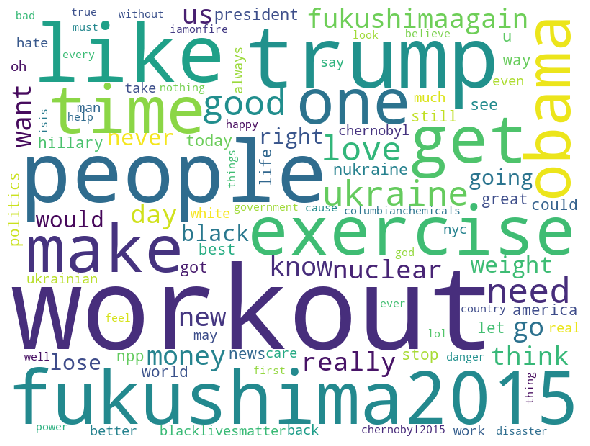

In [19]:
plot_wordcloud(cluster1,save_path="../img/kmeans_cluster1.png")

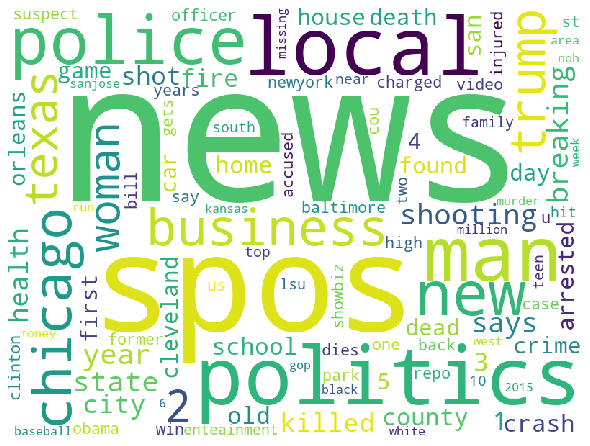

In [20]:
plot_wordcloud(cluster2,"../img/kmeans_cluster2.png")

We clearly found two clusters: The "local" news accounts and the rest. We will now drop the news accounts to free up space and get more into the true content creators.

In [4]:
# Remove news users
users = pd.read_pickle("../data/user_clean.pickle")

# Find news channels
news= ["news" in desc for desc in users.user_profile_description]

# Find the corresponding accounts
news_accounts = users[news]["user_screen_name"]

users_to_keep = set(users.user_screen_name) -  set(news_accounts)

data = data[data.user_screen_name.isin(users_to_keep)]

In [5]:
del users

gc.collect()

28

In [6]:
data.shape

(397105, 108)

We've really cut down the data once we remove the "news" users! Let's try to use DBSCAN for potentially finding more interesting structure.

## DBSCAN

In [7]:
X = data.loc[:,data.columns[-100:]]

In [8]:
# Finding optimal eps based on k-distance graph
from sklearn.neighbors import NearestNeighbors

# Let's take a random subsample

x = X.sample(n =5000).values

ns = 3
nbrs = NearestNeighbors(n_neighbors=ns).fit(x)
distances, indices = nbrs.kneighbors(x)
distanceDec = sorted(distances[:,ns-1], reverse=True)

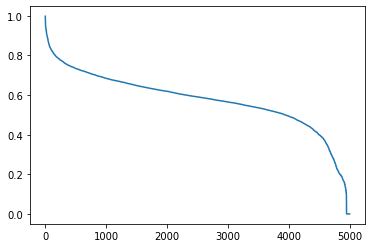

In [9]:
plt.plot(list(range(1,len(distanceDec)+1)), distanceDec)

Let's set $\epsilon$ to 0.5, this is where it drops sharply.

In [10]:
subSample = data.sample(n = 100000,random_state= 1234)

X = data.loc[:,subSample.columns[-100:]].values

# Set up the DBSCAN algorithm
dbscan = DBSCAN(eps =0.5,min_samples= 20,metric ="euclidean",n_jobs=3)

# Fit on our data
dbscan.fit(X)

KeyboardInterrupt: 

In [ ]:
subSample["dbscan_label"] = dbscan.labels_

In [ ]:
subSample.groupby("dbscan_label").count()

In [ ]:
random_sample[random_sample.dbscan_label == 0]["tweet_text"]

In [ ]:
random_sample.to_pickle("../data/tweets_clustered.pickle")

### Cluster on hashtag

In [3]:
hashtags = pd.read_pickle("../data/hashtags.pickle")

In [13]:
blm_idx = hashtags[hashtags[0] == "BlackLivesMatter"].index.get_level_values(0)